## 1. 데이터 셋 확인

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn

# 이 두줄은 본 필자가 항상 쓰는 방법입니다.
# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 
# 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5) 
import missingno as msno

#ignore warnings
import warnings
# 워닝 메세지를 생략해 줍니다. 
# 차후 버전관리를 위해 필요한 정보라고 생각하시면 주석처리 하시면 됩니다.
warnings.filterwarnings('ignore') 

%matplotlib inline

In [3]:
os.listdir("../input")

['test.csv', 'train.csv', 'gender_submission.csv']

In [5]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submit = pd.read_csv('../input/gender_submission.csv')

In [7]:
train.shape, test.shape, submit.shape

((891, 12), (418, 11), (418, 2))

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


우리가 다루는 문제에서 feature는 Pclass, Age, SibSp, Parch, Fare 이며, 예측하려는 target label 은 Survived 입니다.

### 타이타닉 데이터 Feature 설명 

* survival - 생존유무, target 값. (0 = 사망, 1 = 생존)
* pclass - 티켓 클래스. (1 = 1st, 2 = 2nd, 3 = 3rd)
* sex - 성별
* Age - 나이(세)
* sibsp - 함께 탑승한 형제자매, 배우자 수 총합
* parch - 함께 탑승한 부모, 자녀 수 총합
* ticket - 티켓 넘버
* fare - 탑승 요금
* cabin - 객실 넘버
* bembarked - 탑승 항구

### 각 Feature types

In [9]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 결측치 확인

In [13]:
train.isnull().sum() / train.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [15]:
test.isnull().sum() / test.shape[0]

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

train set과 test set에 비슷하게 Age 피쳐에 약 20%, Cabin 피쳐에 약 80%의
결측치가 있음을 확인할 수 있습니다.

### **1.2 Target Label, `Survived` 확인**

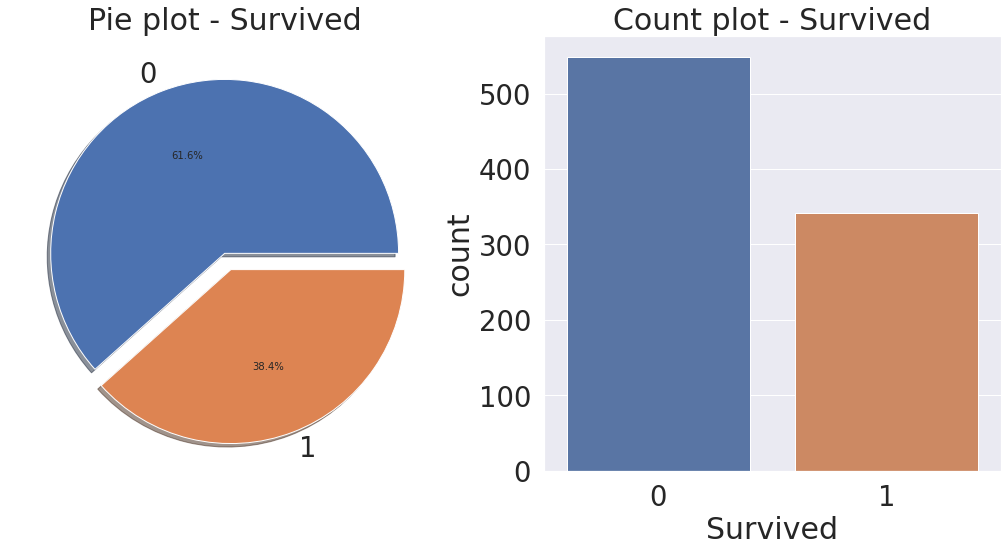

In [20]:
f, ax = plt.subplots(1, 2, figsize = (18, 8))

train['Survived'].value_counts().plot.pie(explode = [0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)

ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')

sns.countplot('Survived', data=train, ax = ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

## 2. 탐색적 데이터 분석 (EDA, Exploratory Data Analysis)

In [21]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [22]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


In [24]:
pd.crosstab(train['Pclass'], train['Survived'], margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [25]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363
